In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path


PROJECTDIR = Path('.').resolve().parents[2]
exp = '../data/mirgenedb21_hsa_expressionPerTissue.txt'
lossfampath = f'{PROJECTDIR}/external_data/all_rodentlost_mirfams.list'
lcapath = '../data/Table_S3_miRNA_loss.tsv'

def read_lossfams(path):
    with open(path) as fh:
        f = [line for line in fh.read().split('\n') if line]
    return f


def read_lca(path):
    old = []
    m = []
    with open(path) as fh:
        header = next(fh)
        for line in fh:
            gain, mirfam = line.split()[:2]
            if gain in ['Vertebrata', 'Gnathostomata']:
                old.append(mirfam)
            elif gain == 'Eutheria':
                m.append(mirfam)
            
    return old, m


def lossfam_expression(exppath, lf, m, old):
    mirfam2exp = {}
    dfcol = []
    with open(exppath, 'r') as fh:
        header = next(fh)
        for line in fh:
            fline = line.strip().split(',')
            mirna = fline.pop(0).split('_')[0]
            mirfam = '-'.join(mirna.split('-')[1:3])
            
            if mirfam in lf:
                mirfam = mirfam
            elif mirfam in old:
                mirfam = 'Vertebrata'
            elif mirfam in m:
                mirfam = 'Eutheria'
            else:
                continue
                
            if not mirfam in mirfam2exp:
                mirfam2exp[mirfam] = []
            mirfam2exp[mirfam].extend(fline)
            #print([mirna] * len(fline))
            dfcol.append(pd.DataFrame({'miRNA': [mirna] * len(fline), 'mirfam': [mirfam] * len(fline), 'tis_expression': fline}))
            
                
    expdf = pd.concat(dfcol)
    expdf['tis_expression'] = expdf['tis_expression'].astype(float)
    return mirfam2exp, expdf

def find_max_exp(indict):
    odict = {}
    for mirfam, stringvals in indict.items():
        all_expressions = np.array(stringvals).astype(float)
        maxexp = all_expressions.max()
        odict[mirfam] = maxexp
    return odict
        
        
    
oldmirs, mammalmirs = read_lca(lcapath)
lossfams = read_lossfams(lossfampath)
alltissue_allmirna, df = lossfam_expression(exp, lossfams, mammalmirs, oldmirs)
maxexpdict = find_max_exp(alltissue_allmirna)
display(df)




,miRNA,mirfam,tis_expression
0,Hsa-Let-7-P1d,Vertebrata,69760.44
1,Hsa-Let-7-P1d,Vertebrata,34650.50
2,Hsa-Let-7-P1d,Vertebrata,18226.13
3,Hsa-Let-7-P1d,Vertebrata,32154.64
4,Hsa-Let-7-P1d,Vertebrata,31863.88
...,...,...,...
40,Hsa-Mir-9851,Mir-9851,0.00
41,Hsa-Mir-9851,Mir-9851,0.00
42,Hsa-Mir-9851,Mir-9851,0.00
43,Hsa-Mir-9851,Mir-9851,0.00


In [41]:
display(df)

,miRNA,mirfam,tis_expression
0,Hsa-Let-7-P1d,Vertebrata,69760.44
1,Hsa-Let-7-P1d,Vertebrata,34650.50
2,Hsa-Let-7-P1d,Vertebrata,18226.13
3,Hsa-Let-7-P1d,Vertebrata,32154.64
4,Hsa-Let-7-P1d,Vertebrata,31863.88
...,...,...,...
40,Hsa-Mir-9851,Mir-9851,0.00
41,Hsa-Mir-9851,Mir-9851,0.00
42,Hsa-Mir-9851,Mir-9851,0.00
43,Hsa-Mir-9851,Mir-9851,0.00


In [42]:
# visdf = df[df.mirfam != 'conserved']
median_per_category = df.groupby('mirfam')['tis_expression'].median().sort_values(ascending=False)
display(median_per_category)

mirfam
Vertebrata    732.13
Mir-1307      695.04
Mir-3613      168.71
Mir-197       115.43
Mir-1277      111.87
Mir-769        37.94
Eutheria       23.33
Mir-885        10.42
Mir-1908        9.03
Mir-766         7.67
Mir-489         4.71
Mir-3200        3.24
Mir-1296        1.57
Mir-506         0.73
Mir-6529        0.00
Mir-9851        0.00
Name: tis_expression, dtype: float64

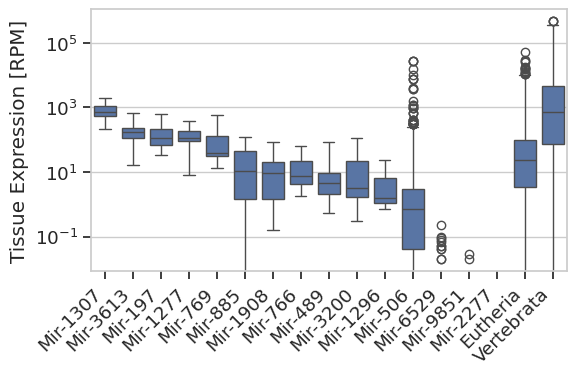

In [44]:
mammalmed = df['tis_expression'][df['mirfam'] == 'Eutherian'].mean()

cmap = sns.color_palette()

norder = [
    'Mir-1307',
    'Mir-3613',
    'Mir-197',
    'Mir-1277',
    'Mir-769',
    'Mir-885',
    'Mir-1908',
    'Mir-766',
    'Mir-489',
    'Mir-3200',
    'Mir-1296',
    'Mir-506',
    'Mir-6529',
    'Mir-9851',
    'Mir-2277',
    'Eutheria',
    'Vertebrata'
]

sns.set(rc={'figure.figsize':(6,4), 'ytick.left': True, 'xtick.bottom': True}, font_scale = 1.2, style='whitegrid')
#sns.boxplot(data=df, x='mirfam', y='tis_expression', hue='type', dodge=False, hue_order=['unconfirmed', 'confirmed'], order=norder)
sns.boxplot(data=df, x='mirfam', y='tis_expression', order=norder, color=cmap[0], whis=100)
#plt.axhline(y=mammalmed, color='dimgrey', linestyle=':')
# plt.axhline(y=oldmed, color='dimgrey', linestyle='--')

plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('Tissue Expression [RPM]')
# plt.ylim([0, 2000])
plt.yscale('log')

plt.tight_layout()
plt.savefig(f'{PROJECTDIR}/publication/revision/mirgene_boxplot_rodlosfams.pdf')
plt.show()